In [1]:
import os
# disable tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook

# Sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# function to compute class weights
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split

#Matplotlib
import matplotlib.pyplot as plt

# Data management libraries
import scipy.io as scio
import numpy as np

In [4]:
data_train = scio.loadmat('Data/tumor_train_data.mat')
data_val = scio.loadmat('Data/tumor_val_data.mat')
data_test = scio.loadmat('Data/tumor_test_data.mat')

#data_train = scio.loadmat('/content/tumor_train_data.mat')
#data_val = scio.loadmat('/content/tumor_val_data.mat')
#data_test = scio.loadmat('/content/tumor_test_data.mat')
N = 64 # image size (64x64 after preprocessing)

In [5]:
train = np.transpose(data_train['img_train'], (2, 0, 1)).reshape(-1, N, N, 1)
train_y = data_train['labels_train']
val = np.transpose(data_val['img_val'], (2, 0, 1)).reshape(-1, N, N, 1)
val_y = data_val['labels_val']
test = np.transpose(data_test['img_test'], (2, 0, 1)).reshape(-1, N, N, 1)
test_y = data_test['labels_test']

In [6]:
classes = ['glioma', 'miningioma', 'no tumour', 'pituitary']
num_epochs = 30 # how many training epochs we are doing

In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(N,N,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same"),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [8]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(lr=0.001),
              metrics=['accuracy'])
model.summary()
history = model.fit(train, train_y,
                        batch_size=100,
                        epochs=num_epochs,
                        validation_data=(val, val_y))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         614656    
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 256)        1024      
 hNormalization)                                                 
                                                        

C:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
C:\Users\61424\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 8s 403ms/step - loss: 2.0123 - accuracy: 0.2962 - val_loss: 2.2786 - val_accuracy: 0.2630
Epoch 2/30
20/20 [==============================] - 8s 418ms/step - loss: 1.5959 - accuracy: 0.3933 - val_loss: 2.2322 - val_accuracy: 0.2630
Epoch 3/30
20/20 [==============================] - 8s 423ms/step - loss: 1.3423 - accuracy: 0.4734 - val_loss: 2.1729 - val_accuracy: 0.2630
Epoch 4/30
20/20 [==============================] - 8s 408ms/step - loss: 1.2295 - accuracy: 0.5220 - val_loss: 2.1032 - val_accuracy: 0.2630
Epoch 5/30
20/20 [==============================] - 8s 406ms/step - loss: 1.1228 - accuracy: 0.5506 - val_loss: 2.0277 - val_accuracy: 0.2630
Epoch 6/30
20/20 [==============================] - 8s 401ms/step - loss: 1.0366 - accuracy: 0.5904 - val_loss: 1.9547 - val_accuracy: 0.2630
Epoch 7/30
20/20 [==============================] - 9s 430ms/step - loss: 0.9835 - accuracy: 0.6073 - val_loss: 1.8987 - val_accuracy: 0.2630
Epoch 8/30
20/20 

              precision    recall  f1-score   support

           0       0.55      0.82      0.66        98
           1       0.77      0.69      0.73       192
           2       0.92      0.38      0.54       185
           3       0.68      0.98      0.80       179

    accuracy                           0.70       654
   macro avg       0.73      0.72      0.68       654
weighted avg       0.75      0.70      0.68       654



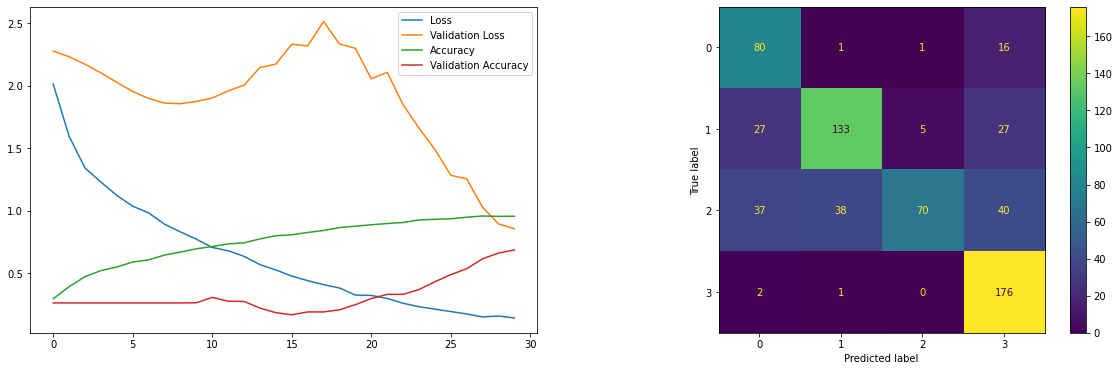

In [9]:
def eval_model(model, history, x_train, y_train, x_test, y_test):

    fig = plt.figure(figsize=[20, 6])    

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history['loss'], label='Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['accuracy'], label='Accuracy')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.legend()
    
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)

    ax = fig.add_subplot(1, 2, 2)
    c = ConfusionMatrixDisplay(cm, display_labels=range(len(np.unique(y_test))))
    c.plot(ax = ax)
    
    print(classification_report(y_test, indexes))

eval_model(model, history.history, train, train_y, test, test_y)